# Word2Vec Embeddings: Google Pretrained Word2Vec Vectors

In [531]:
# Imports and Set Options

import csv  # for slang
import os
import re  # regex
import string  # punct
from pprint import pprint

import emoji  # for emoji
import gensim
import keras
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from gensim.models import KeyedVectors, Word2Vec
from IPython.display import Image
from matplotlib import pyplot as plt
from nltk.corpus import stopwords  # stopwords
from nltk.stem import PorterStemmer  # stemming
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import svm, tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, RandomForestRegressor,
                              StackingClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             brier_score_loss, classification_report,
                             confusion_matrix, f1_score, fbeta_score,
                             make_scorer, plot_precision_recall_curve,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC  # "Support vector classifier"
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

## Text Cleaning Class

- Implemented as a sklearn `Estimator` with (obligatory) `fit` and `transform` methods. 
- Additional `transform_no_stem` method returns cleaned texts without stemming, producing appropriate input for Word2Vec, which expects complete word tokens (as appeared in its training corpus). 

In [482]:
# Clean Text Class

class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        '''
        Remove mentions, like @Mplamplampla
        '''
        return re.sub(r'@+', '', input_text)
    
    def remove_urls(self, input_text):
        '''
        Remove the urls mention in a tweet
        '''
        input_text  = ' '.join([w for w in input_text.split(' ') if '.com' not in w])
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        input_text = input_text.replace('_','')
        input_text = input_text.replace(':','')
        return input_text
    
    def possessive_pronouns(self, input_text):
        '''
        Remove the possesive pronouns, because otherwise after tokenization we will end up with a word and an s
        Example: government's --> ["government", "s"]
        '''
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        '''
        Remove special and redundant characters that may appear on a tweet and that don't really help in our analysis
        '''
        input_text = input_text.replace("\r", " ") # Carriage Return
        input_text = input_text.replace("\n", " ") # Newline
        input_text = " ".join(input_text.split()) # Double space
        input_text = input_text.replace('"', '') # Quotes
        return input_text
    
    def remove_punctuation(self, input_text):
        '''
        Remove punctuation and specifically these symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        '''
        punct = string.punctuation # string with all the punctuation symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        '''
        Remove numbers
        '''
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        '''
        Convert all the sentences(words) to lowercase
        '''
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        '''
        Remove stopwords (refers to the most common words in a language)
        '''
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        '''
        Reduce the words to their stem
        '''
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def encode_decode(self, input_text):
        '''
        Remove weird characters that are result of encoding problems
        '''
        return  " ".join([k.encode("ascii", "ignore").decode() for k in input_text.split(" ")])
    
    
    def translator(self, input_text):
        '''
        Transform abbrevations to normal words
        Example: asap --> as soon as possible
        '''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = r"slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that 
                # abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords)
                    .apply(self.stemming))
        return clean_X
    
    def transform_no_stem(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords))
        return clean_X

## Load Word2Vec via the `gensim.downloader` API

In [483]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

## Import Data

In [556]:
tweets = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')

# NOT RUN. For consistency across methods with other input datasets, these usernames have *not* been removed. 
# Optional: Remove errant rows; usernames '318', '54' or '96'
# tweets.drop(tweets[tweets.username.isin(['318', '54', '96'])].index, inplace=True)

## Text Cleaning

- No stemming
- Removal of one errant row

In [557]:
ct = CleanText()
ct.fit(tweets.text)
tweets["text_clean"] = ct.transform_no_stem(tweets.text)

In [562]:
tweets.head()

,Unnamed: 0,username,user_handle,date,retweets,favorites,text,label,text_clean
0,0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0,economic recovery national climate pledges mus...
1,1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0,difficult time hard connect natural world eart...
2,2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0,decision postpone cop unavoidable collective p...
3,3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0,japan worlds fifth largest emitter greenhouse ...
4,4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0,countries include naturebasedsolutions climate...


In [563]:
# View rows with null `text_clean` value

tweets.loc[(tweets.text_clean.isnull()), :] 

,Unnamed: 0,username,user_handle,date,retweets,favorites,text,label,text_clean
2062,2062,96,222,We,if we choose to be. But there is a difference...,disruptive and completely catastrophic. And w...,very much.https://www.nytimes.com/2019/11/19/...,0,NaN


In [564]:
# Remove rows with null `text_clean` value

tweets = tweets.loc[(~tweets.text_clean.isnull()), :]

## Save Results

In [565]:
tweets.to_csv("clean_tweets_no_stemming.csv") # save once processed
tweets = pd.read_csv("clean_tweets_no_stemming.csv") # read in instead

## Add clean text field containing only words known to pretrained Word2Vec

In [566]:
tweets["text_clean_known"] = tweets.text_clean.apply(func=lambda tweet: ' '.join([word for word in tweet.split() \
                                                                               if word in wv.vocab]))
print(f"Count of text_clean_known entries which are null: {sum(tweets.text_clean_known.isnull())}")
print(f"Count of text_clean_known entries which empty: \
{sum(tweets.text_clean_known.apply(func=lambda x: x.strip() == ''))}")

# Remove both rows with either null or empty `text_clean_known` entries

tweets = tweets.loc[(~tweets.text_clean_known.isnull()), :]
tweets = tweets.loc[~tweets.text_clean_known.apply(func=lambda x: x.strip() == ''), ]

print("After cleaning:", end="\n")
print(f"Count of text_clean_known entries which are null: {sum(tweets.text_clean_known.isnull())}")
print(f"Count of text_clean_known entries which empty: {sum(tweets.text_clean_known.apply(func=lambda x: x.strip() == ''))}")

Count of text_clean_known entries which are null: 0
Count of text_clean_known entries which empty: 3
After cleaning:
Count of text_clean_known entries which are null: 0
Count of text_clean_known entries which empty: 0


## Calculate Tweet Vectors

#### Implement Tweet Vectorizer: Word2VectorizeTweet

- Retrieves vector for words (where possible; although input here is clean, there is a fallback for unrecognised word keys)
- **Takes (component-wise; arithmetic) mean of word vectors to calculate a _tweet vector_**
- Tracks number of words for which vector entries exist in the (pre-trained) vocabulary (used for average)

NB Could have done this by precalcuting number of token per tweet document given that we have clean and known (to Word2Vec) input, but I kept the function as it was before, when I was using input that optionally contained _unknown_ words. Not sure if the speed improvement is critical. 

In [569]:
def Word2VectorizeTweet(tweet):
    tweet_vector = np.zeros(shape=(300,), dtype="float32")
    n_vectorizable = 0
    for word in tweet.split():
        try:
#             print(f"Adding {word} to word representation")
            tweet_vector = np.add(tweet_vector, wv.get_vector(word))
            n_vectorizable += 1
        except KeyError:
            print(f"Could not vectorize {word}")
    return (tweet_vector/n_vectorizable)

In [570]:
tweets["wv"] = tweets.text_clean_known.apply(func=Word2VectorizeTweet)

## Create Word2Vec-Representation Input Dataset - Vector Mean Method

In [580]:
w2v_train, w2v_test, Y_train, Y_test = train_test_split(np.array(tweets.wv.tolist()), tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

[print(dat[:3], dat.shape, end="\n"*2) for dat in [w2v_train, w2v_test, Y_train, Y_test]];

[[ 0.00756226  0.06903076 -0.01115723  0.185083   -0.16228637  0.01247559
   0.05341492 -0.07486572  0.04592896  0.10591812 -0.02705688 -0.11100464
  -0.03353882 -0.00517578 -0.15960693  0.1170166   0.02597656  0.15979004
   0.04359131 -0.06125488 -0.01443481  0.02495117  0.11098633  0.04191894
   0.02767887  0.04990234 -0.08166198  0.01254883  0.04807129 -0.02866821
  -0.03339844 -0.0260376  -0.08784332 -0.04694519  0.06231689 -0.05767517
   0.04456787  0.08453369  0.07069091  0.01975098  0.05698242 -0.02724304
   0.0932373   0.06208496 -0.01950684 -0.0621582  -0.00041504  0.08579101
  -0.2020874   0.04884949  0.03145752  0.01223144 -0.07353516 -0.17507324
  -0.03920899  0.02390747 -0.06101685 -0.13779297  0.01408691 -0.1177002
  -0.01579971  0.07027588 -0.13205567 -0.12597656  0.01966553 -0.04987793
  -0.00275269  0.07321777 -0.10512695  0.00593262  0.03122559  0.04464569
   0.07122803 -0.00961304 -0.15692139 -0.04655151  0.08242188  0.20649414
  -0.0019043   0.09255371  0.05478706  

## Visualisation of Tweets

Open the figure elsewhere (e.g. another browser tab) and pan around to read the tweets (messy but quick solution to viewing).

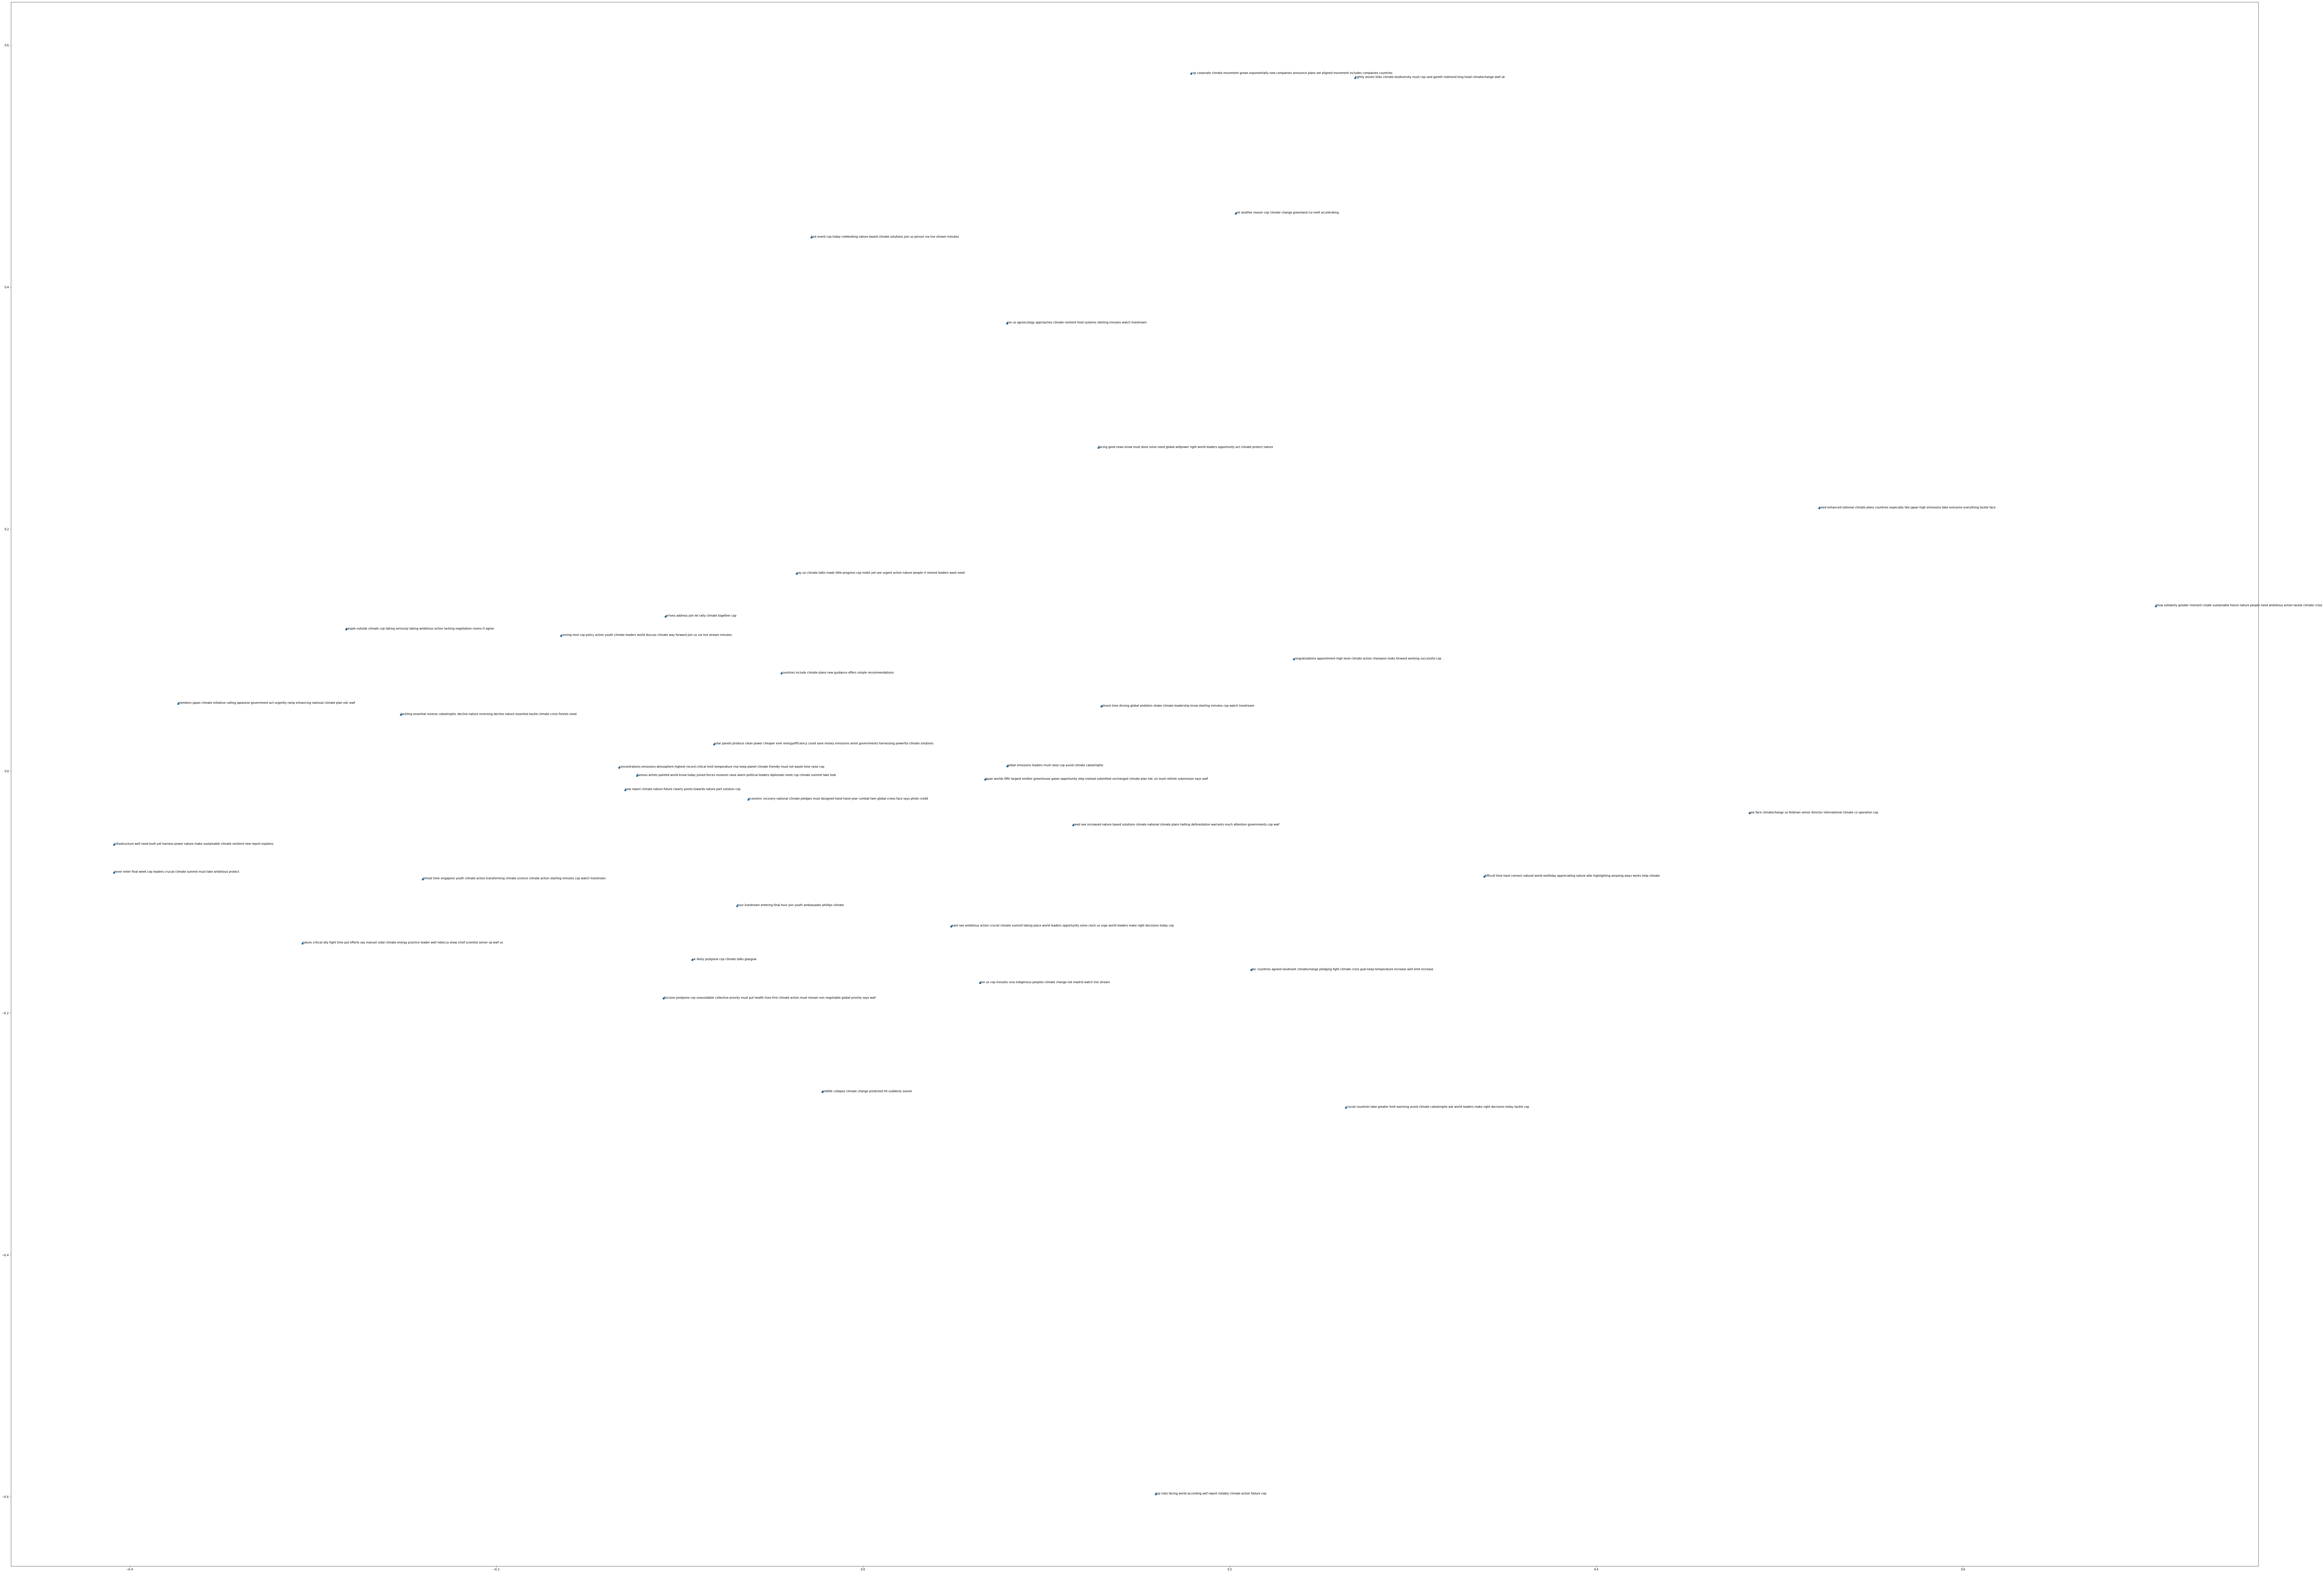

In [577]:
plt.figure(figsize=(140, 100))

pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_train)

plt.scatter(pca_results[:40, 0], pca_results[:40, 1])

for i, text in enumerate(list(tweets.text_clean_known)[:40]):
    plt.annotate(text[:], xy=(pca_results[i, 0], pca_results[i, 1]))
plt.show()

## Example Classifier: Penalised Logistic Regression

In [598]:
w2v_logreg_elnet = LogisticRegressionCV(Cs=10, # equiv: np.logspace(-4, 4, num=10, base=10)
                                        l1_ratios=np.linspace(0, 1, num=5),
                                        penalty="elasticnet", 
                                        solver="saga", # for elasticnet
                                        random_state=17, # for solver
                                        n_jobs=-1) # use all CPUs

w2v_logreg_elnet.fit(w2v_train, Y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                     max_iter=100, multi_class='auto', n_jobs=-1,
                     penalty='elasticnet', random_state=17, refit=True,
                     scoring=None, solver='saga', tol=0.0001, verbose=0)

#### Best Classification Cross-Validated Error

In [601]:
max(w2v_logreg_elnet.scores_[1].flatten())

0.8611593196806664

#### Test Set Error

In [605]:
w2v_test_pred_prob = w2v_logreg_elnet.predict_proba(w2v_test)
w2v_test_pred = w2v_logreg_elnet.predict(w2v_test)

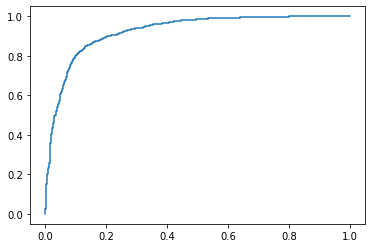

In [620]:
roc_test = roc_curve(Y_test, w2v_test_pred_prob[:, 1])

tpr_test = roc_test[0]
fpr_test = roc_test[1]
thresh_test = roc_test[2]
plt.plot(tpr_test, fpr_test); 

In [606]:
print(confusion_matrix(Y_test, w2v_test_pred))

[[1184  285]
 [ 236 1896]]


In [604]:
print(classification_report(Y_test, w2v_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1469
           1       0.87      0.89      0.88      2132

    accuracy                           0.86      3601
   macro avg       0.85      0.85      0.85      3601
weighted avg       0.85      0.86      0.85      3601

